In [ ]:
!pip install statsforecast utilsforecast
!pip install mlforecast utilsforecast lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.6/354.6 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.7/280.7 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.3
    Uninstalling scipy-1.16.3:
      Successfully uninstalled scipy-1.16.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.4/72.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 11.1 MB/s eta 0:00:00


#This notebook covers my exploration of LGBM for the VN1 Forecasting competition. Please view my GitHub for the Google Doc that goes along with this, along with the input files.

##At a high level the workflow is:
###Import packages
###Import and format data for Phase0
###Exploratory Data Analysis
###Benchmarking with StatsForecast
###Create ML Forecast
###Ensemble models
###Load Phase 1. Create new Ensemble model.
###Get Phase 2 results

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import scipy.stats as stats
from scipy.stats import norm
import lightgbm as lgb
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from mlforecast import MLForecast
from mlforecast.lag_transforms import RollingMean, RollingStd, RollingQuantile
from mlforecast.target_transforms import Differences
from lightgbm import LGBMRegressor

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsforecast import StatsForecast
from statsforecast.models import Naive, HistoricAverage, WindowAverage, SeasonalNaive, Theta
from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import *

In [ ]:
#import data for Phase 0
price_df = pd.read_csv('Phase 0 - Price.csv')
sales_df = pd.read_csv('Phase 0 - Sales.csv')


#change pricing to tabular
price_df_long = price_df.melt(id_vars=["Client", "Warehouse", "Product"],
                        var_name="ds", value_name="Price")

#change sales to tabular
sales_df_long = sales_df.melt(id_vars=["Client", "Warehouse", "Product"],
                        var_name="ds", value_name="y")

#merge
df = pd.merge(price_df_long, sales_df_long, on=["Client", "Warehouse", "Product", "ds"])


#format
df["ds"] = pd.to_datetime(df["ds"])

#change columns to categories
df = df.astype({"Price": "float32",
                "y": "float32",
                "Client": "category",
                "Warehouse": "category",
                "Product": "category"})

In [ ]:
#some functions to count the number of unique_ids, or Product-Warehouse-Client combinations we need to forecast
clients_count = df['Client'].nunique()
print("number of clients:", clients_count)

warehouse_count = df['Warehouse'].nunique()
print("number of warehouses:",warehouse_count)

product_count = df['Product'].nunique()
print("number of products:",product_count)

print("max number of forecast ids:", warehouse_count * clients_count * product_count)

number of clients: 46
number of warehouses: 328
number of products: 11171
max number of forecast ids: 168548048


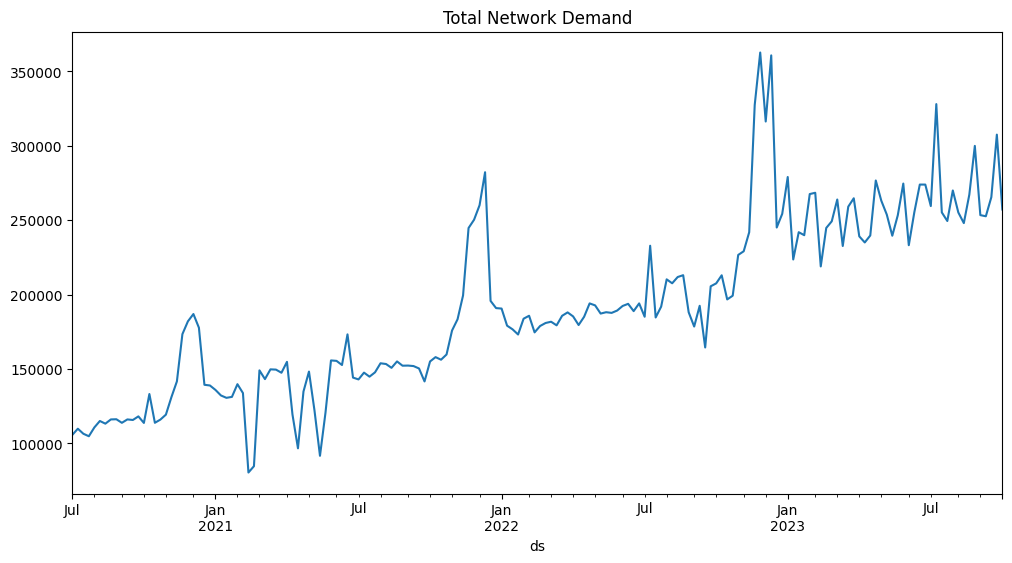

In [ ]:
sales_df_long['ds'] = pd.to_datetime(sales_df_long['ds'])
sales_df_long = sales_df_long.set_index('ds', drop=False).sort_index()
plot = sales_df_long.groupby(level=0)['y'].sum().plot(figsize=(12,6), title="Total Network Demand")

In [ ]:
sales_df_long['Month'] = sales_df_long.index.month
sales_df_long['Quarter'] = sales_df_long.index.quarter
sales_df_long['Year'] = sales_df_long.index.year

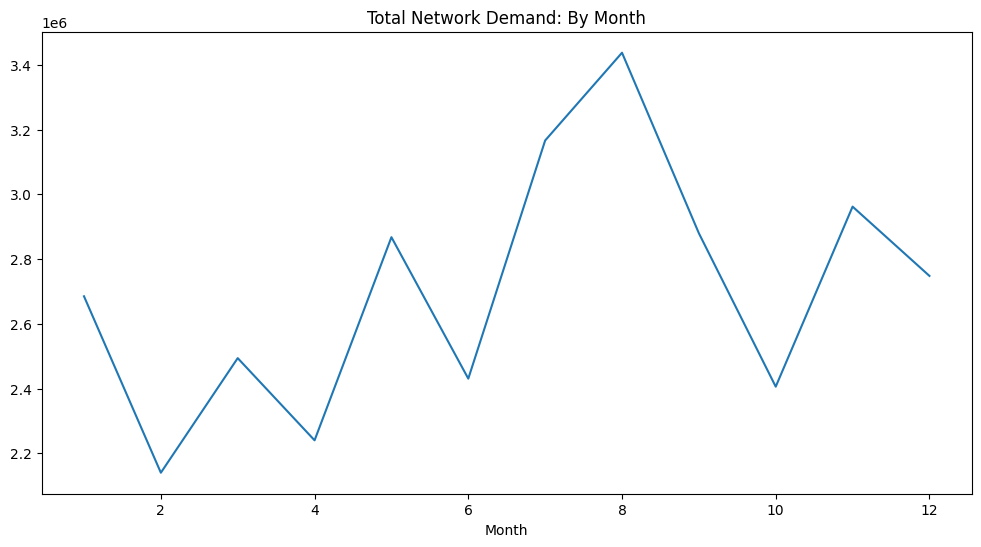

In [ ]:
month_plot = sales_df_long.groupby('Month')['y'].sum().plot(figsize=(12,6), title="Total Network Demand: By Month")

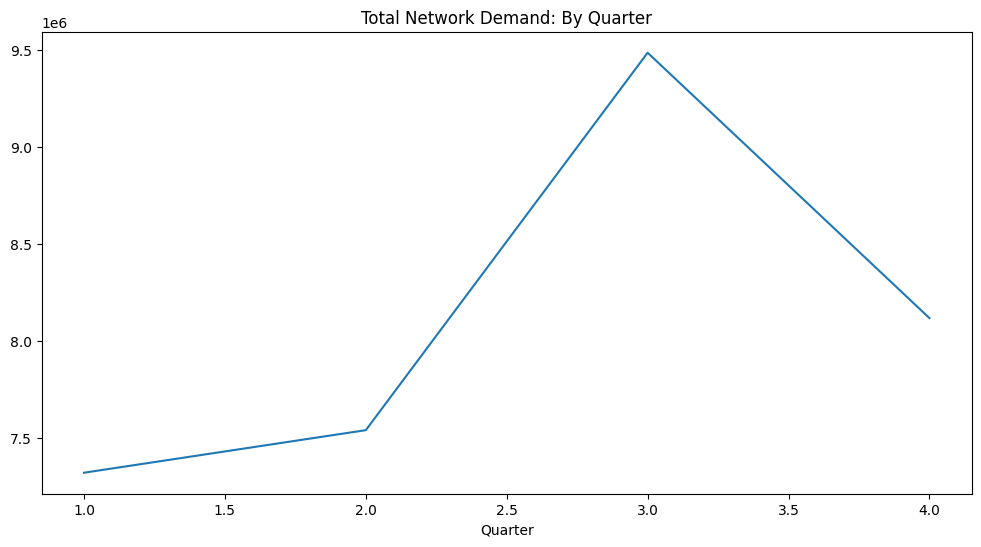

In [ ]:
quarter_plot = sales_df_long.groupby('Quarter')['y'].sum().plot(figsize=(12,6), title="Total Network Demand: By Quarter")

In [ ]:
#Define levels which will be used for more EDA

level_1 = 'Warehouse'
level_2 = 'Client'
level_3 = 'Product'

#Define variables which can be used to make the notebook more modular
#id_field = 'node'
value_field = 'y'
time_field = 'ds'

In [ ]:
#set a seed for reproducability
seed = 54

#custom EDA function
def plot_grid(df, level, n=9):
    """This is a function which takes a dataframe, and a level of that dataframe as an input.
    It outputs 9 random charts at a predefined level. """
    df[time_field] = pd.to_datetime(df[time_field])

    #pick a random subset. For example, get a list of random warehouse id's
    random_subset = df[level].drop_duplicates().sample(n, random_state=seed).tolist()

    #create grid with 3 rows and 3 columns.. sharex = true makes every grid use the same time horizon
    fig, axes = plt.subplots(3, 3, figsize=(18, 12), sharex=False)

    #this makes the axes (or boxes) a 1 dimensional list that we can loop through
    axes = axes.flatten()

    #loop through
    for i in range(n):

        #grab the warehouse id
        name = random_subset[i]

        #target a certain box in the grid
        ax = axes[i]

        #filter and aggregate the data frame
        data = df[df[level] == name].groupby(level=0)[value_field].sum()

        #plot to the specific 'ax'
        ax.plot(data.index, data.values, color='steelblue')
        ax.set_title(f"{level}: {name}", fontsize=10)

        #make date labels sparse
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))

        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%y'))

    #tilt dates
    #fig.autofmt_xdate()

    #increase space between charts
    fig.subplots_adjust(hspace=0.4)

    #show plot
    plt.show()

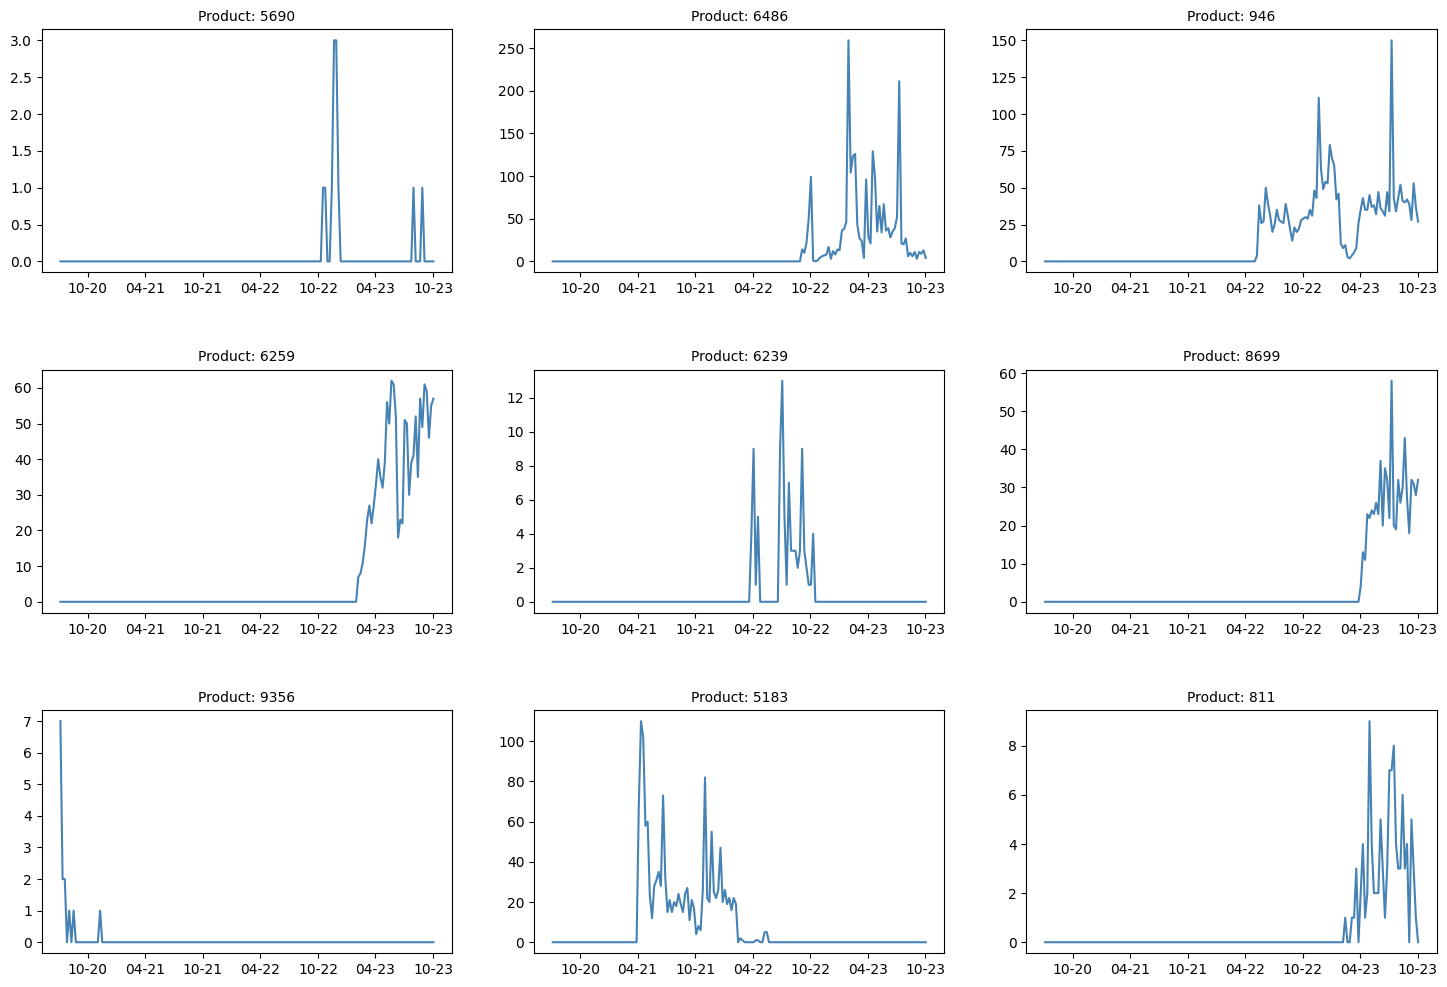

In [ ]:
#plot random subsets
plot_grid(sales_df_long, level_3)

In [ ]:
#sort the data
df.sort_values(['Product', 'Client', 'Warehouse']).sort_index()

,Client,Warehouse,Product,ds,Price,y
0,0,1,367,2020-07-06,10.900001,7.0
1,0,1,639,2020-07-06,NaN,0.0
2,0,1,655,2020-07-06,21.343332,21.0
3,0,1,1149,2020-07-06,11.480000,7.0
4,0,1,1485,2020-07-06,NaN,0.0
...,...,...,...,...,...,...
2559005,46,318,13485,2023-10-02,26.952000,80.0
2559006,46,318,13582,2023-10-02,24.679487,39.0
2559007,46,318,13691,2023-10-02,52.990002,1.0
2559008,46,318,13946,2023-10-02,30.990000,3.0


In [ ]:
#we'll start to create a 13 week forecast. First we'll make unique_ids
df['unique_id'] = (df['Product'].astype(str) + '-' + df['Client'].astype(str) + '-' + df['Warehouse'].astype(str))

In [ ]:
#benchmark models with StatsForecast
horizon = 13

models = [
    Naive(),
    HistoricAverage(),
    WindowAverage(window_size=4),
    SeasonalNaive(season_length=52),
    Theta(season_length=52)
]

sf = StatsForecast(models=models, freq="W-MON")
sf.fit(df=df)
stats_preds = sf.predict(h=horizon)

In [ ]:
#import phase1 data for backtesting
phase1 = pd.read_csv('Phase 1 - Sales.csv')

phase1_sales_long = phase1.melt(
    id_vars=["Product", "Client", "Warehouse"],
    var_name="Week Start",
    value_name ="Sales")

phase1_sales_long['unique_id'] = (phase1_sales_long['Product'].astype(str) + '-' + phase1_sales_long['Client'].astype(str) + '-' + phase1_sales_long['Warehouse'].astype(str))
phase1_sales_long['ds'] = phase1_sales_long['Week Start']
phase1_sales_long['y'] = phase1_sales_long['Sales']

phase1_sales_long['ds'] = pd.to_datetime(phase1_sales_long['ds'])




In [ ]:
#merge data to backtest
eval_df_phase1 = stats_preds.merge(phase1_sales_long[['unique_id','ds','y']],
                          on=['unique_id','ds'],
                          how='left')


In [ ]:
#define the competition score (MAPE + BIAS)

#competition score

def competition_score(df, forecast, demand):

  abs_error = np.nansum(abs(df[forecast] - df[demand]))

  total_error = np.nansum(df[forecast] - df[demand])

  score = abs_error + abs(total_error)

  score /= df[demand].sum().sum()

  return score

In [ ]:
score = competition_score(eval_df_phase1, 'WindowAverage', 'y')
print("Window Avg", np.round(score,2))
score = competition_score(eval_df_phase1, 'SeasonalNaive', 'y')
print("Seasonal Naive", np.round(score,2))
score = competition_score(eval_df_phase1, 'HistoricAverage', 'y')
print("HistoricAverage", np.round(score,2))
score = competition_score(eval_df_phase1, 'Theta', 'y')
print("Theta", np.round(score,2))

Window Avg 0.64
Seasonal Naive 0.89
HistoricAverage 1.12
Theta 0.56


###This shows Theta is a formidable model, which beats a window average by 800 bps.

###Now we're going to create a forecast with LGBM using MLForecast.
###We are using a recursive implementation. Meaning we create a forecast for T+1w, and then we update all the features to be based on the new forecast to create a prediction for T+2w, etc. To do this we have to create some functions to extract features and lags for each new prediction

In [ ]:
#create a function to recursively get date features
def date_features(df):
    df["week"] = df["ds"].dt.isocalendar().week #isocalendar().week ensures each week 1 has 7 days
    df["month"] = df["ds"].dt.month
    df["year"] = df["ds"].dt.year

    return df



In [ ]:
#create a function to recursively get rolling mean data
def lag_transforms(mean_lag_transform_wks = [2, 4], med_lag_transform_wks = [2, 4]):
    lag_transforms = []
    for lag in mean_lag_transform_wks:
        lag_transforms.append(RollingMean(window_size=lag))
    for lag in med_lag_transform_wks:
        lag_transforms.append(RollingQuantile(window_size=lag, p=0.5))

    return lag_transforms


In [ ]:
#create a function to recursively get lags
def lags(lags = [1,2,4]):
  return lags

In [ ]:
df = df.sort_values(by=["unique_id", "ds"]).reset_index(drop=True)
df.head()

,Client,Warehouse,Product,ds,Price,y,unique_id
0,0,3,0,2020-07-06,NaN,0.0,0-0-3
1,0,3,0,2020-07-13,NaN,0.0,0-0-3
2,0,3,0,2020-07-20,NaN,0.0,0-0-3
3,0,3,0,2020-07-27,NaN,0.0,0-0-3
4,0,3,0,2020-08-03,NaN,0.0,0-0-3


In [ ]:
df = df.rename(columns={'Week': 'week', 'Month': 'month', 'Year': 'year'}) #MLForecast needs these lowercase

In [ ]:
df = date_features(df)
df.head()

,Client,Warehouse,Product,ds,Price,y,unique_id,week,month,year
0,0,3,0,2020-07-06,NaN,0.0,0-0-3,28,7,2020
1,0,3,0,2020-07-13,NaN,0.0,0-0-3,29,7,2020
2,0,3,0,2020-07-20,NaN,0.0,0-0-3,30,7,2020
3,0,3,0,2020-07-27,NaN,0.0,0-0-3,31,7,2020
4,0,3,0,2020-08-03,NaN,0.0,0-0-3,32,8,2020


In [ ]:
df.drop(['Price'], axis=1, inplace=True)


In [ ]:
#start to create the model
horizon = 13
freq = "W-MON"

In [ ]:
models = LGBMRegressor(
    n_estimators=200,
    objective="tweedie",
    metric="mae",
    learning_rate=0.05, #L1/L2 did not work well
    importance_type="gain",
    verbosity =-1
)

In [ ]:
#create an MLForecast instance
mf = MLForecast(
    models = models,
    freq=freq,
    lags=lags(),
    lag_transforms={
        1: lag_transforms()
        #52: ly_rmed_lag_transforms()
    },
    date_features=['week','month','year']
)


In [ ]:
#fit the model to the data
mf.fit(df,
         id_col='unique_id',
         target_col='y',
         time_col='ds',
         static_features=['Product','Client','Warehouse'])

MLForecast(models=[LGBMRegressor], freq=W-MON, lag_features=['lag1', 'lag2', 'lag4', 'rolling_mean_lag1_window_size2', 'rolling_mean_lag1_window_size4', 'rolling_quantile_lag1_p0.5_window_size2', 'rolling_quantile_lag1_p0.5_window_size4'], date_features=['week', 'month', 'year'], num_threads=1)

In [ ]:
ml_preds = mf.predict(h=13)

In [ ]:
phase1_sales_long.head()

,Product,Client,Warehouse,Week Start,Sales,unique_id,ds,y
0,367,0,1,2023-10-09,1.0,367-0-1,2023-10-09,1.0
1,639,0,1,2023-10-09,5.0,639-0-1,2023-10-09,5.0
2,655,0,1,2023-10-09,6.0,655-0-1,2023-10-09,6.0
3,1149,0,1,2023-10-09,1.0,1149-0-1,2023-10-09,1.0
4,1485,0,1,2023-10-09,0.0,1485-0-1,2023-10-09,0.0


In [ ]:
#merge data to backtest
eval_df_phase1 = ml_preds.merge(phase1_sales_long[['unique_id','ds','y']],
                          on=['unique_id','ds'],
                          how='left')


In [ ]:
score = competition_score(eval_df_phase1, 'LGBMRegressor', 'y')
print("LGBM", np.round(score,3))

LGBM 0.692


In [ ]:
#merge data to backtest
eval_df_phase1 = eval_df_phase1.merge(stats_preds[['unique_id','ds','Theta']],
                          on=['unique_id','ds'],
                          how='left')


In [ ]:
eval_df_phase1['ensemble_fcst'] = eval_df_phase1['LGBMRegressor'] * .3 + eval_df_phase1['Theta'] * .7  #30% / 70% split provided the best accuracy in phase 1

In [ ]:
score = competition_score(eval_df_phase1, 'ensemble_fcst', 'y')
print("Ensemble Model for Phase 1: ", np.round(score,4))

Ensemble Model for Phase 1:  0.5305


In [ ]:
df.drop(['week', 'month', 'year'], axis=1, inplace=True)

In [ ]:
phase1_sales_long.drop(['Week Start', 'Sales'], axis=1, inplace=True)

In [ ]:
#merge dfs
df2 = pd.concat([df, phase1_sales_long])
#sort
df2 = df2.sort_values(by=["unique_id", "ds"]).reset_index(drop=True)

In [ ]:
#first we'll create the Theta model
horizon = 13

st_models = [
    Theta(season_length=52)
]

sf2 = StatsForecast(models=st_models, freq="W-MON")
sf2.fit(df=df2)
stats2_preds = sf2.predict(h=horizon)


In [120]:
ml_models = LGBMRegressor(
    n_estimators=200,
    objective="tweedie",
    metric="mae",
    learning_rate=0.05, #L1/L2 did not work well
    importance_type="gain",
    verbosity =-1
)

In [121]:
#create an MLForecast instance
mf2 = MLForecast(
    models = ml_models,
    freq=freq,
    lags=lags(),
    lag_transforms={
        1: lag_transforms()
    },
    date_features=['week','month','year']
)


In [113]:
#fit the model to the data
mf2.fit(df=df2,
         id_col='unique_id',
         target_col='y',
         time_col='ds',
         static_features=['Product','Client','Warehouse'])

MLForecast(models=[LGBMRegressor], freq=W-MON, lag_features=['lag1', 'lag2', 'lag4', 'rolling_mean_lag1_window_size2', 'rolling_mean_lag1_window_size4', 'rolling_quantile_lag1_p0.5_window_size2', 'rolling_quantile_lag1_p0.5_window_size4', 'rolling_quantile_lag52_p0.5_window_size2'], date_features=['week', 'month', 'year'], num_threads=1)

In [114]:
ml2_preds = mf2.predict(h=13)

In [115]:
#merge data to backtest
eval_df_phase2 = stats2_preds.merge(ml2_preds[['unique_id','ds','LGBMRegressor']],
                          on=['unique_id','ds'],
                          how='left')

In [116]:
eval_df_phase2['ensemble_fcst'] = eval_df_phase2['LGBMRegressor'] * .3 + eval_df_phase2['Theta'] * .7

In [117]:
#import phase2 data for backtesting
phase2 = pd.read_csv('Phase 2 - Sales.csv')

phase2_sales_long = phase2.melt(
    id_vars=["Product", "Client", "Warehouse"],
    var_name="Week Start",
    value_name ="Sales")

phase2_sales_long['unique_id'] = (phase2_sales_long['Product'].astype(str) + '-' + phase2_sales_long['Client'].astype(str) + '-' + phase2_sales_long['Warehouse'].astype(str))
phase2_sales_long['ds'] = phase2_sales_long['Week Start']
phase2_sales_long['y'] = phase2_sales_long['Sales']

phase2_sales_long['ds'] = pd.to_datetime(phase2_sales_long['ds'])

In [118]:
#merge data to backtest
eval_df_phase2 = eval_df_phase2.merge(phase2_sales_long[['unique_id','ds','y']],
                          on=['unique_id','ds'],
                          how='left')

In [ ]:
eval_df_phase2.tail()

,unique_id,ds,Theta,LGBMRegressor,ensemble_fcst,y
195684,9998-34-325,2024-03-04,0.331759,0.869684,0.493136,0.0
195685,9998-34-325,2024-03-11,0.316439,0.869684,0.482412,0.0
195686,9998-34-325,2024-03-18,0.301118,0.869684,0.471688,1.0
195687,9998-34-325,2024-03-25,0.285798,0.869684,0.460964,0.0
195688,9998-34-325,2024-04-01,0.270477,0.869061,0.450052,0.0


In [119]:
score = competition_score(eval_df_phase2, 'ensemble_fcst', 'y')
print("Ensemble Model score for final test set: ", np.round(score,3))

Ensemble Model score for final test set:  0.554
